In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt

RANDOM_SEED = 20250416

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))


housing = load_housing_data()


In [2]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [3]:
housing.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


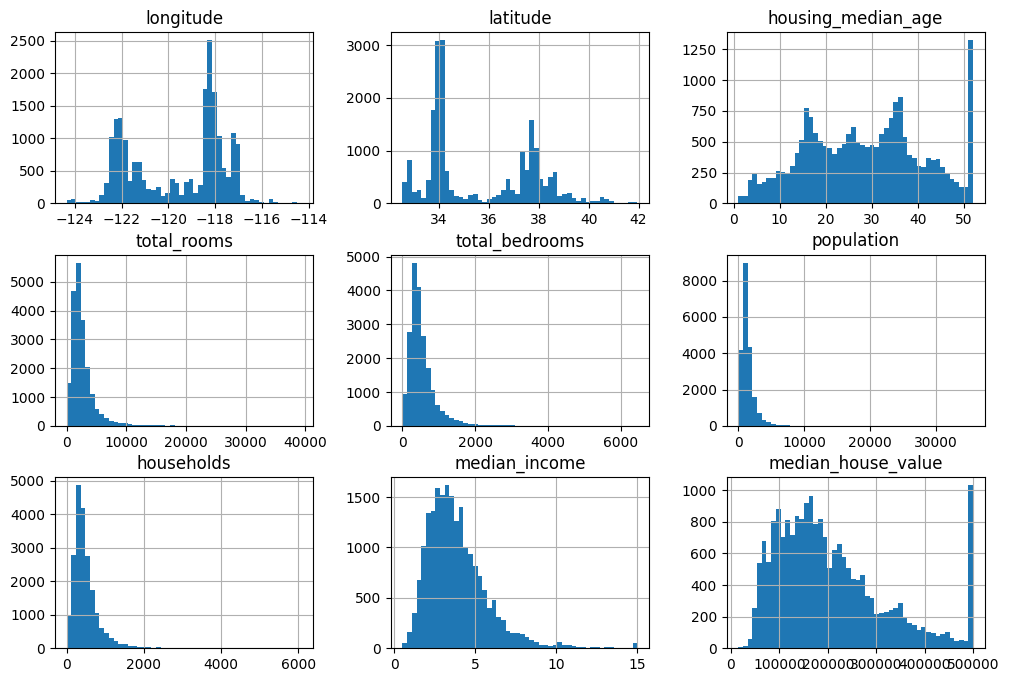

In [6]:
# Median Income: Computed as tens of thousands (3 => 30.000USD), and capped at 15
# Median Age & House Value: Capped as well 
# Attributes have different scales
# Many as skewed to the right: The median is far to the right in the data distribution

housing.hist(bins=50, figsize=(12,8))
plt.show()

## Creating a Test Set

In [7]:
import numpy as np

np.random.seed(RANDOM_SEED)

# Manual test split using numpy
def shuffle_and_split_data(data, ratio):
    shuffled_indices = np.random.permutation(len(data))
    print(shuffled_indices)
    
    test_size = int(len(data) * ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]

    return data.iloc[train_indices], data.iloc[test_indices]


shuffle_and_split_data(housing, .2)


[ 3596 14609  8923 ... 14281  6958  8384]


(       longitude  latitude  ...  median_house_value  ocean_proximity
 19950    -117.98     34.04  ...            190600.0        <1H OCEAN
 10101    -122.31     38.00  ...            170800.0         NEAR BAY
 13073    -117.38     33.98  ...            101600.0           INLAND
 16664    -122.31     40.45  ...             60400.0           INLAND
 18828    -121.42     37.74  ...            152500.0           INLAND
 ...          ...       ...  ...                 ...              ...
 9053     -117.13     32.76  ...            162500.0       NEAR OCEAN
 7143     -118.04     33.98  ...            163300.0        <1H OCEAN
 14281    -118.46     34.20  ...            205600.0        <1H OCEAN
 6958     -120.02     37.72  ...             88100.0           INLAND
 8384     -119.72     36.81  ...             87500.0           INLAND
 
 [16512 rows x 10 columns],
        longitude  latitude  ...  median_house_value  ocean_proximity
 3596     -121.95     37.35  ...            236100.0        

In [8]:
from zlib import crc32

# Creating a refresh-proof spliting of the dataset
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32 


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set] 


# Create an "id" to the dataset being its row number
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, .2, "index")

len(train_set), len(test_set)

(16512, 4128)

In [9]:
# ALTERNATIVE: Combine both the longitude and latitude into a single identifier
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

len(train_set), len(test_set)

(16322, 4318)

In [10]:
from sklearn.model_selection import train_test_split

# Same as shuffle_and_split_data() 
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=RANDOM_SEED)

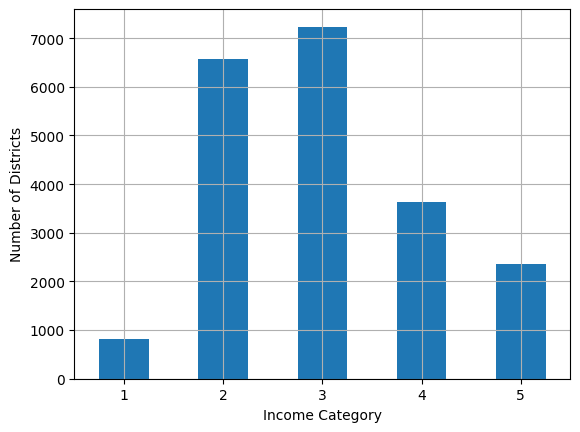

In [11]:
# Creating stratas for stratified spliting of our data by median income
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts");

In [12]:
# Create the stratified split 

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)
strat_splits = []

# Creates 10 different splits
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

# ... but we'll use only one right now
strat_train_set, strat_test_set = strat_splits[0]

In [13]:
# Does the same thing above 
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=RANDOM_SEED)

# Seeing if the proportions in the splitted dataset hold up 
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [14]:
# Now comparing to the full dataset
housing['income_cat'].value_counts() / len(housing) # Pretty darn close!

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [15]:
# Dropping the income_cat column, as we'll not be using it!
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


## Visualizing Geographical Data

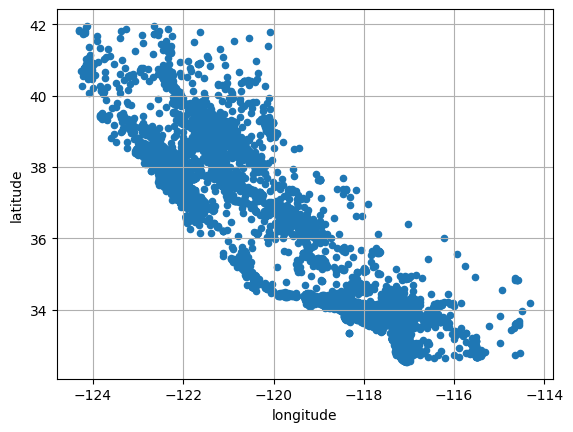

In [16]:
housing = strat_train_set.copy()

# Holy FUCKING S H I T THAT'S CALIFORNIA
# TODAY IS FRAIDAY ON CALIFORNIA
housing.plot(kind="scatter", x="longitude", y='latitude', grid='True')
plt.show();

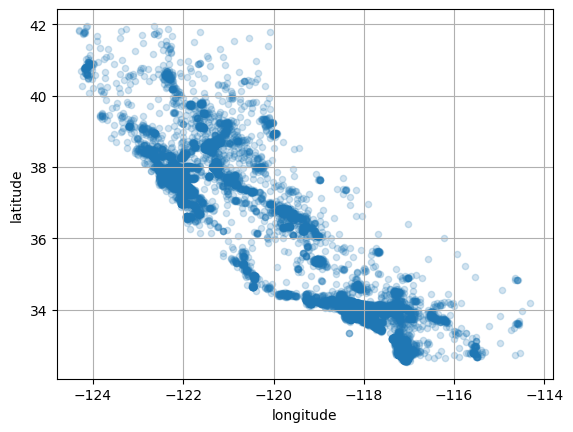

In [17]:
housing.plot(kind="scatter", x="longitude", y='latitude', grid='True', alpha=.2)
plt.show();

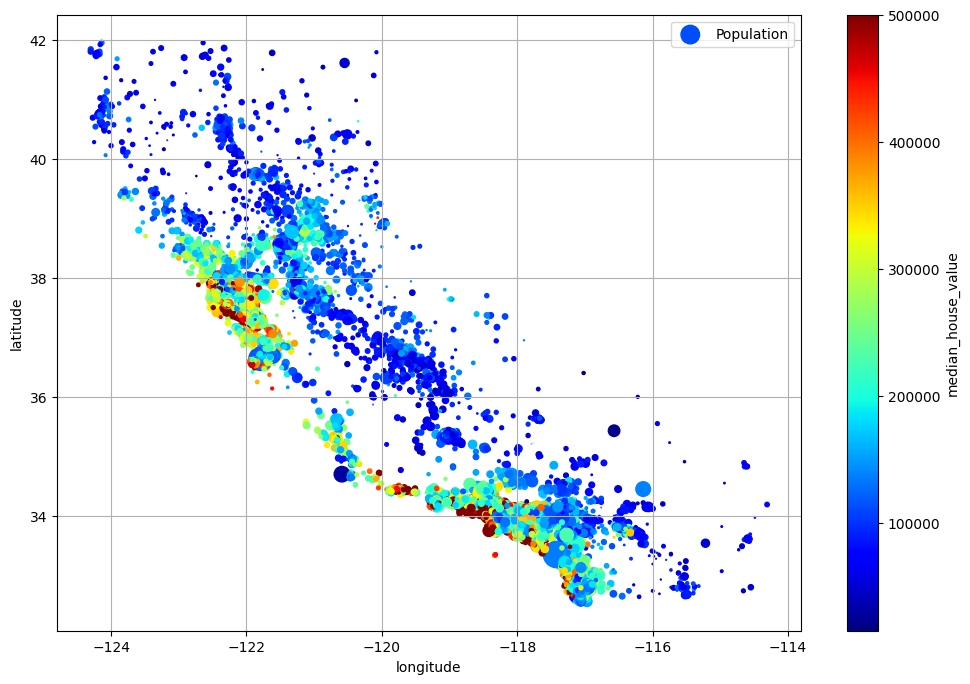

In [18]:
# Red -> More Expensive
# Blue -> Less Expensive
housing.plot(kind="scatter", x='longitude', y='latitude', grid='True',
             s=housing['population']/100, label='Population',
             c="median_house_value", cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(12,8));


## Correlations Everywhere

In [19]:
corr_matrix = housing.drop(['ocean_proximity'], axis='columns').corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687689
total_rooms           0.133529
housing_median_age    0.103825
households            0.066022
total_bedrooms        0.049917
population           -0.021848
longitude            -0.048371
latitude             -0.142667
Name: median_house_value, dtype: float64

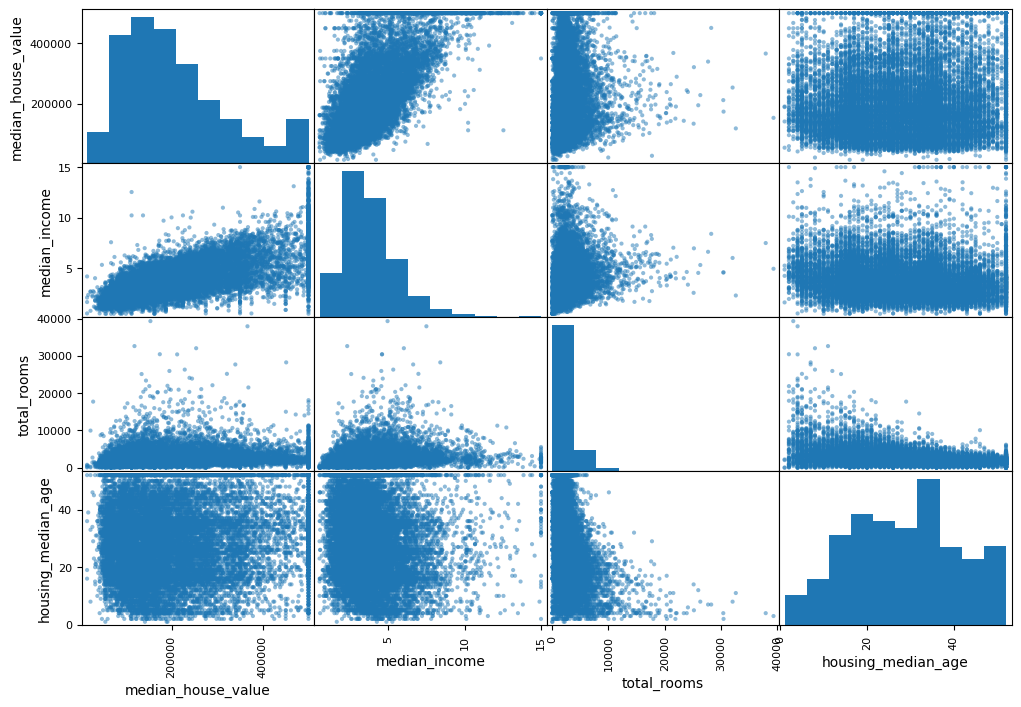

In [20]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
    "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12,8), diagonal='hist');

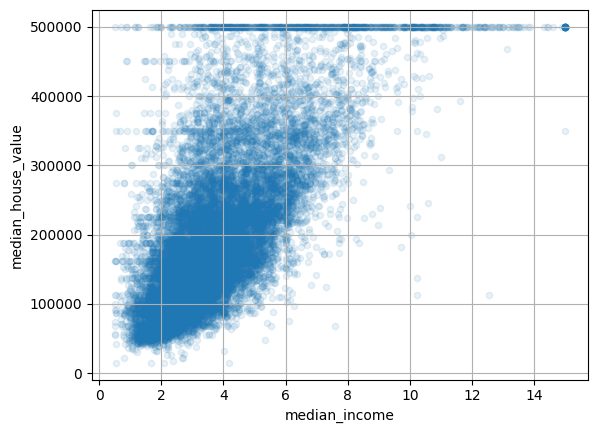

In [21]:
# Taking a look at median-house-value vs. median-income
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True);

# Strong correlation, although it has its quirks

##  Mixing and Matching Attributes

In [22]:
# Creating new attributes that mix and match to see if we have better correlations
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']


In [23]:
# Well, we kinda of do!
corr_matrix = housing.drop(['ocean_proximity'], axis='columns').corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687689
rooms_per_house       0.149061
total_rooms           0.133529
housing_median_age    0.103825
households            0.066022
total_bedrooms        0.049917
population           -0.021848
people_per_house     -0.022405
longitude            -0.048371
latitude             -0.142667
bedrooms_ratio       -0.256745
Name: median_house_value, dtype: float64

## Preparing for Machine Learning 

In [24]:
# Copy the dataset 
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

# Get the Nulls out of there

# housing.dropna(subset=['total_bedrooms'], inplace=True) # Option 1 

# housing.drop("total_bedrooms", axis=1) # Options 2 

# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True) # Option 3

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2125.    ,  435.    , 1166.    ,
        409.    ,    3.5293])

In [26]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [27]:
from sklearn.preprocessing import OrdinalEncoder

# Categorical attributes
housing_cat = housing[["ocean_proximity"]]
print(housing_cat.head(8))

# Fitter 
ordinal = OrdinalEncoder() 
housing_cat_encoded = ordinal.fit_transform(housing_cat)


housing_cat_encoded[:8]

      ocean_proximity
3871        <1H OCEAN
2541       NEAR OCEAN
12345          INLAND
5116        <1H OCEAN
3011        <1H OCEAN
17284       <1H OCEAN
3116       NEAR OCEAN
7542       NEAR OCEAN


array([[0.],
       [4.],
       [1.],
       [0.],
       [0.],
       [0.],
       [4.],
       [4.]])

In [28]:
from sklearn.preprocessing import OneHotEncoder 

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [29]:
# Shittier version using only pandas 

df_test = pd.DataFrame({ 'ocean_proximity': ['INLAND', 'NEAR BAY']})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [30]:
print(cat_encoder.feature_names_in_ )

cat_encoder.get_feature_names_out()

['ocean_proximity']


array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

## Feature Scaling

In [31]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
# Do not fit or fit_transform in the validation/test data!!!!! 
# If the range of the new data is greater than it was fitted, set clip=True
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num) 
housing_num_min_max_scaled

array([[ 0.20520521, -0.68969182,  0.60784314, ..., -0.95027888,
        -0.91940789, -0.89270493],
       [-0.5975976 ,  0.05844846,  0.25490196, ..., -0.89719443,
        -0.74703947, -0.33094716],
       [-0.05905906, -0.1434644 ,  0.25490196, ..., -0.93262143,
        -0.87269737, -0.8160853 ],
       ...,
       [-0.3973974 ,  0.23698193, -0.37254902, ..., -0.93581659,
        -0.87828947, -0.44451801],
       [-0.4954955 ,  0.61105207, -0.49019608, ..., -0.99820623,
        -0.99506579, -0.22263141],
       [-0.54554555,  0.21785335, -0.09803922, ..., -0.89035567,
        -0.76019737, -0.69262493]])

In [32]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
housing_num_std_scaler = standard_scaler.fit_transform(housing_num)

housing_num_std_scaler

array([[ 0.64340557, -0.76405978,  1.06793105, ..., -0.46693371,
        -0.65429864, -1.37087725],
       [-1.35804566,  0.88283325,  0.35247858, ...,  0.35524022,
         0.69904088,  0.78627835],
       [-0.01542626,  0.43835928,  0.35247858, ..., -0.19345453,
        -0.28755396, -1.07665707],
       ...,
       [-0.85893064,  1.27584181, -0.91943691, ..., -0.24294124,
        -0.33146001,  0.35016513],
       [-1.103497  ,  2.09928833, -1.15792107, ..., -1.20923436,
        -1.24832171,  1.20221194],
       [-1.22827575,  1.23373375, -0.36297389, ...,  0.46115915,
         0.59573252, -0.602568  ]])

In [33]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)
age_simil_35

array([[7.44658307e-03],
       [6.70320046e-01],
       [6.70320046e-01],
       ...,
       [8.48904403e-15],
       [7.04065961e-20],
       [5.55951324e-06]])

In [34]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5] # Pretend it's new data

scaled_predictions = model.predict(some_new_data)
# Standard scaled
print(scaled_predictions)


predictions = target_scaler.inverse_transform(scaled_predictions)
# Normal scale
predictions

[[-0.94273659]
 [ 0.54071462]
 [-0.74040474]
 [ 0.83800221]
 [ 0.03002248]]


array([[ 98178.72478341],
       [269413.10954694],
       [121533.83692644],
       [303728.93768581],
       [210464.04971661]])

In [35]:
from sklearn.compose import TransformedTargetRegressor

# Same fucking thing as above
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)

predictions = model.predict(some_new_data)
predictions

array([ 98178.72478341, 269413.10954694, 121533.83692644, 303728.93768581,
       210464.04971661])

## Custom Transformers

In [36]:
# Creating a transformer for normalizing the data into a log
# To avoid left skewed data
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])
log_pop

,population
3871,6.791221
2541,7.515889
12345,7.094235
5116,6.142037
3011,6.336826
...,...
1247,6.561031
1013,6.347389
4941,7.045777
14088,3.555348


In [37]:
# RBF Transformer 
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])
age_simil_35

array([[7.44658307e-03],
       [6.70320046e-01],
       [6.70320046e-01],
       ...,
       [8.48904403e-15],
       [7.04065961e-20],
       [5.55951324e-06]])

In [38]:
# Add a feature that will measure the geographic similarity between each district and San Francisco

sf_coords = [37.7749, -122.41]
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])
sf_simil

array([[0.04368821],
       [0.99209402],
       [0.39266895],
       ...,
       [0.85242146],
       [0.55452721],
       [0.96179649]])

In [39]:
# Custom classes for fitter-transformer customs
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerCopy(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True) -> None:
        self.with_mean = with_mean 

    def fit(self, X, y=None): # y is very much so required
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # Every estimator stores this is fit

        return self
    
    def transform(self, X):
        check_is_fitted(self) # Looks for trailing _ attributes
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]

        if self.with_mean:
            X = X = self.mean_

        return X / self.scale_


### To Consider
- Scikit-Learn pipelines require the fit() method to have two arguments X
and y, which is why we need the y=None argument even though we
don’t use y.
- All Scikit-Learn estimators set n_features_in_ in the fit() method, and
they ensure that the data passed to transform() or predict() has this
number of features.
- The fit() method must return self.
- This implementation is not 100% complete: all estimators should set
feature_names_in_ in the fit() method when they are passed a
DataFrame. Moreover, all transformers should provide a
get_feature_names_out() method, as well as an inverse_transform()
method when their transformation can be reversed. See the last exercise
at the end of this chapter for more details.


Transformers can use other transformers, like this:

In [40]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_labels)

similarities[:3].round(2)

array([[0.  , 0.76, 0.  , 0.99, 0.  , 0.06, 0.  , 0.  , 0.07, 0.  ],
       [0.18, 0.  , 0.88, 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.84],
       [0.03, 0.  , 0.  , 0.  , 0.  , 0.03, 0.99, 0.  , 0.  , 0.  ]])

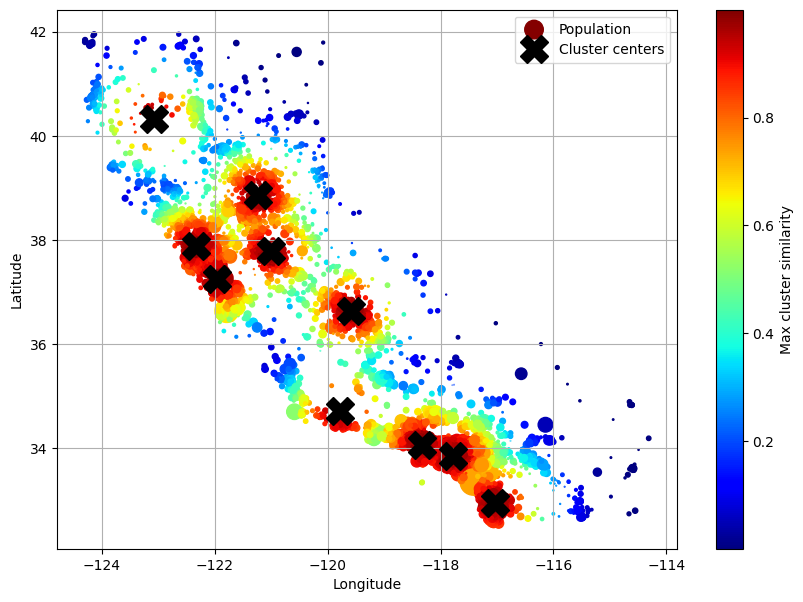

In [41]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

## Transformation Pipelines

In [42]:
from sklearn.pipeline import Pipeline, make_pipeline

housing_num = housing.select_dtypes(include=[np.number])

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='median')),
    ("standard", StandardScaler())
])

# Same thing, just with no names for the steps
# num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

num_pipeline

,steps,"[('impute', ...), ('standard', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [43]:
housing_num = housing.select_dtypes(include=[np.number])

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[ 0.64, -0.76,  1.07, -0.81, -0.6 , -0.47, -0.65, -1.37],
       [-1.36,  0.88,  0.35,  0.66,  0.5 ,  0.36,  0.7 ,  0.79]])

In [44]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, 
    columns=num_pipeline[:-1].get_feature_names_out(),
    index=housing_num.index
)

In [45]:
# Preparing everything 
from sklearn.compose import ColumnTransformer

num_attribs = [
    "longitude", "latitude", "housing_median_age", "total_rooms",
    "total_bedrooms", "population", "households", "median_income"
]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)


preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])


from sklearn.compose import make_column_selector, make_column_transformer

# Same thing from above, just *classier* (or functioner, heh)
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

housing_prepared = preprocessing.fit_transform(housing)

## Ultimate Pipeline

In [46]:
def column_ratio(X): # Create a new attribute from two others in the dataset
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)

housing_prepared = preprocessing.fit_transform(housing)
print(housing_prepared.shape)
preprocessing.get_feature_names_out() # Holy FUCK!

(16512, 24)


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Now For The Models

In [47]:
# Training a supah-basic linear regression 
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
housing_predictions = lin_reg.predict(housing)
print(housing_predictions[:5].round(-2)) # Kinda shit ngl

# Answers
housing_labels.iloc[:5].values

[ 96800. 352100.  39200. 300800. 265900.]


array([112500., 388100.,  68300., 405800., 230000.])

In [49]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions) 
lin_rmse # Quite sheit innit mate?

69867.34504094347

In [ ]:
# Try decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=RANDOM_SEED))
tree_reg.fit(housing, housing_labels)


housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse # Perfect?? Can't be

0.0

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score 

# Create 10 non-overlapping "folds", than randomly picks one to be the validation fold
# and train a model with the 9 others, does that 10 times
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
    scoring="neg_root_mean_squared_error", cv=10)

tree_rmses # Utility function (aka, greater is better)

array([65948.89563348, 67780.81981849, 63583.6475101 , 68866.78786198,
       66953.72977202, 69865.31838002, 62014.86794949, 66453.74432081,
       62744.07862467, 66697.51666419])

In [55]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66090.940654
std       2585.718520
min      62014.867949
25%      64174.959541
50%      66575.630493
75%      67574.047307
max      69865.318380
dtype: float64

In [56]:
# Now we try random forests 
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, 
                    scoring="neg_root_mean_squared_error", cv=10)

forest_rmses 

array([50297.73182824, 48088.09502042, 43701.00370964, 46512.43485892,
       48053.10254678, 48442.8932303 , 43745.69614675, 44949.13610554,
       44516.85632864, 50090.91298516])

In [ ]:
pd.Series(forest_rmses).describe() # Better than the tree, but could be better!

count       10.000000
mean     46839.786276
std       2508.444529
min      43701.003710
25%      44624.926273
50%      47282.768703
75%      48354.193678
max      50297.731828
dtype: float64

In [58]:
# Grid Search for the better model
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=RANDOM_SEED))
])

param_grid = [
    {
        'preprocessing__geo__n_clusters': [5, 8, 10],
        'random_forest__max_features': [4, 6, 8]
    },
    {
        'preprocessing__geo__n_clusters': [10, 15],
        'random_forest__max_features': [6, 8, 10]
    },
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [65]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)

# these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]

# rmse = -score
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head() # Somewhat Better!

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,44049,43679,43149,43626
13,15,8,44537,44239,43513,44096
6,10,4,44931,44607,44026,44521
14,15,10,45119,44938,44162,44740
7,10,6,45260,44895,44293,44816


In [66]:
# Now for the RandomSearch!
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 

param_distribs =  {
    'preprocessing__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20)
}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10,
                                cv=3, scoring='neg_root_mean_squared_error', random_state=RANDOM_SEED)

rnd_search.fit(housing, housing_labels)

,estimator,Pipeline(step...e=20250416))])
,param_distributions,"{'preprocessing__geo__n_clusters': <scipy.stats....x7e7c5f7955e0>, 'random_forest__max_features': <scipy.stats....x7e7c5f796e70>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,20250416
,error_score,nan


In [67]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head() 

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
4,47,9,42677,42003,41598,42093
1,49,11,42844,42125,41628,42199
6,40,10,42846,42231,41769,42282
8,40,12,43255,42647,41968,42623
5,23,6,43573,42731,42275,42860


In [68]:
final_model = rnd_search.best_estimator_
feature_importance = final_model['random_forest'].feature_importances_
feature_importance.round(2)

array([0.06, 0.06, 0.04, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.02, 0.01, 0.02,
       0.01, 0.01, 0.02, 0.01, 0.03, 0.01, 0.02, 0.01, 0.01, 0.  , 0.01,
       0.  , 0.07, 0.  , 0.  , 0.  , 0.01])

In [72]:
sorted(zip(feature_importance, final_model['preprocessing'].get_feature_names_out()), reverse=True)

[(np.float64(0.18493162445899522), 'log__median_income'),
 (np.float64(0.07063307339103782), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.061761988192735984), 'bedrooms__ratio'),
 (np.float64(0.057002145641316615), 'rooms_per_house__ratio'),
 (np.float64(0.04372683033231179), 'people_per_house__ratio'),
 (np.float64(0.030636667650651258), 'geo__Cluster 40 similarity'),
 (np.float64(0.026050318626363617), 'geo__Cluster 18 similarity'),
 (np.float64(0.02303447300246308), 'geo__Cluster 20 similarity'),
 (np.float64(0.01984662365156031), 'geo__Cluster 30 similarity'),
 (np.float64(0.018761423502871976), 'geo__Cluster 19 similarity'),
 (np.float64(0.018683659257245543), 'geo__Cluster 33 similarity'),
 (np.float64(0.018046032227095762), 'geo__Cluster 38 similarity'),
 (np.float64(0.017653331379945816), 'geo__Cluster 3 similarity'),
 (np.float64(0.01714708598415189), 'geo__Cluster 35 similarity'),
 (np.float64(0.015030551853495422), 'geo__Cluster 42 similarity'),
 (np.float64(0.014908677028

## Evaluating The Whole Shebang

In [74]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse) # prints 41424.40026462184


40988.1140288958


In [75]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors))
)


array([38901.34556253, 42973.66980741])

## Launching Into Space

In [76]:
import joblib 

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel


joblib.dump(final_model, 'california_housing_model.pkl')

['california_housing_model.pkl']

In [ ]:
# Any custom transformers must be loaded into the production code when using this model!!
final_model_reloaded = joblib.load("california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
predictions


array([111779., 384281.,  67609., 366146., 232530.])